In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm import tqdm
import os
from PIL import Image

In [4]:
def calculateHeat(cellTemp, neighborTemps, gamma):
    cellTemp = cellTemp + gamma*((neighborTemps[0] -2*cellTemp + neighborTemps[-1]) + (neighborTemps[1] -2*cellTemp + neighborTemps[-2]))
    #print(cellTemp)
    return np.float64(cellTemp)

def heatTransfer(grid, boundaryTemp, B_i):
    for i in range(0,len(grid)):
        for j in range(0,len(grid)):
            neighbors = getNeighborsTemperature(grid[:,:,0], (i,j), boundaryTemp, B_i)
            grid[:,:,0][i][j] = calculateHeat(grid[:,:,0][i][j], neighbors, grid[:,:,1][i][j])
    return grid

def calculateAverageTemperatureWithinCircle(grid, center, radius):
    # Extract the temperature values from the grid
    temperatures = grid[:, :, 0]

    # Create a mask for the circle
    x, y = np.indices(temperatures.shape)
    mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

    # Calculate the average temperature within the circle
    average_temperature = np.mean(temperatures[mask])
    
    return average_temperature

In [5]:
# Array to save data
temp_array = [[],[],[],[]]

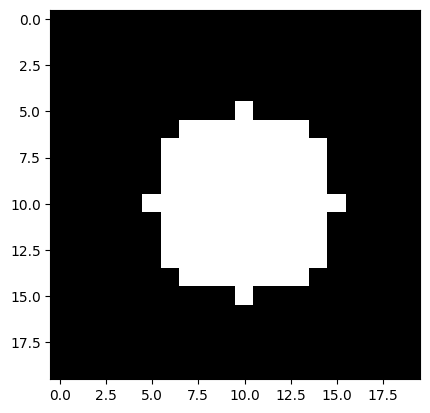

100%|██████████| 800/800 [00:02<00:00, 308.16it/s]


In [6]:
###...................................................Robin boundary condition...................................................###
# Functions
def getNeighborsTemperature(grid, point, T_inf,B):
    neighbors = []
    
    rows = len(grid)
    cols = len(grid[0])

    for i in range(-1, 2):
        for j in range(-1, 2):
            try:
                if abs(i) != abs(j):
                    neighbor_temp = grid[point[0] + i][point[1] + j]
                    neighbors.append(neighbor_temp)
            except IndexError:
                ###...Edge or corner point...###
                # Upper edge point:
                if point[0] == 0:
                    # upper left corner point
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0] + 1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    # upper right corner point
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    # upper edge
                    else:
                        boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf-grid[point[0]][point[1]])
                        neighbors.append(boundary_temp)
                
                # lower edge point
                elif point[0] == rows - 1:
                    # Lower left corner
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0]+1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower right corner
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower edge
                    else:
                        boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                        neighbors.append(boundary_temp)
                
                # left edge
                elif point[1] == 0:
                    boundary_temp = grid[point[0]+1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                    neighbors.append(boundary_temp)
                
                # right edge
                elif point[1] == cols - 1:
                    boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                    neighbors.append(boundary_temp)

    return neighbors

def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/Robin/"+ str(counter)+ '_'+ ".png")
                images.append(imageio.imread("frames/Robin/"+ str(counter)+ '_'+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)

time = []

###.........Heat simulation with highest fill factor.........###
#Make mesh grid
resolution = 20
startingTemperature = 103.15 # Round about -170C°
gamma = 0.249
timeStep = 0.00078
boundaryTemp = 103.15
B_i = 0.18

#Add heat
radius_1 = 5
center_1 = (10, 10)
value_to_add = 492.2
radius_heat = 5

#Configure the grid
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
fullGridY = np.dstack([gridY,gridY2])

# create meshgrid coordinates
x = np.arange(resolution)
y = np.arange(resolution)
# create meshgrid for the x,y coordinates
X, Y = np.meshgrid(x, y)
# Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
distances = np.sqrt((X - center_1[0])**2 + (Y - center_1[1])**2)
# Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
mask = distances <= radius_1
# Aktualisiere die Werte im Gitter entsprechend der Maske
fullGridX[:,:,0][mask] += value_to_add

# Plot the created mask
white_image = Image.new('L', (20, 20), 255)
white_image = white_image * mask
plt.imshow(white_image,cmap='gray')
#plt.scatter(10,10, color = "red")
plt.show()

#Run simulation
frames = [fullGridX[:,:,0].copy()]

average_temperatures_in_circle = []
temp_array[0] = []
for t in tqdm(range(0,800)):
        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(fullGridX, center_1, radius_heat)
        temp_array[0].append(average_temp_in_circle)
        
        # Calculate the heat
        fullGridX = heatTransfer(fullGridX.copy(),boundaryTemp, B_i)
        frames.append(fullGridX[:,:,0].copy())


#Make Gif, saves as "simulation.gif"
#makeGif_single(frames,"Robin",timeStep,103.15,500)

In [17]:

specific_point = float(timeStep*801)
step_size = timeStep

time_step_array =  np.arange(0, specific_point-timeStep, step_size)

# Nano seconds
time_step_array = [element * 100 for element in time_step_array]
len(time_step_array)


file_path_robin = 'boundary_robin_array.txt'

np.savetxt(file_path_robin,temp_array[0], delimiter=',', newline='\n', fmt='%f')

robin_array = np.loadtxt(file_path_robin, delimiter=',')
print(len(robin_array))
print(len(time_step_array))


800
800


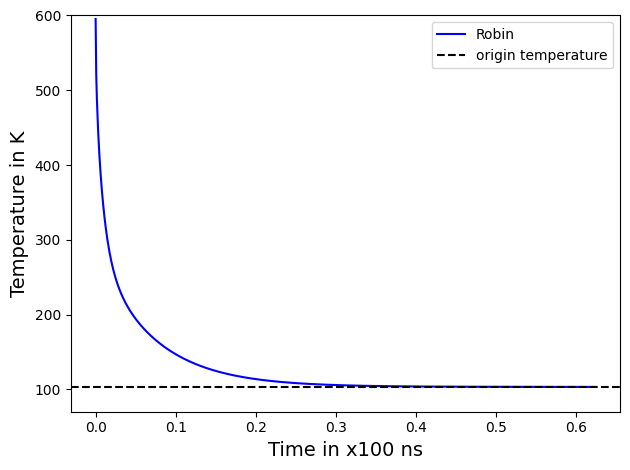

In [77]:
#Plot the Result
plt.minorticks_on
plt.xlabel(r'Time in x100 ns', fontsize="14")
plt.ylabel(r"Temperature in K", fontsize="14")


plt.plot(time_step_array, robin_array, color= "blue", label = "Robin")

# Show line where the CDW Spots arge gone
plt.axhline(y=103.15, color='black', linestyle='--', label='origin temperature')
plt.ylim(70, 600)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

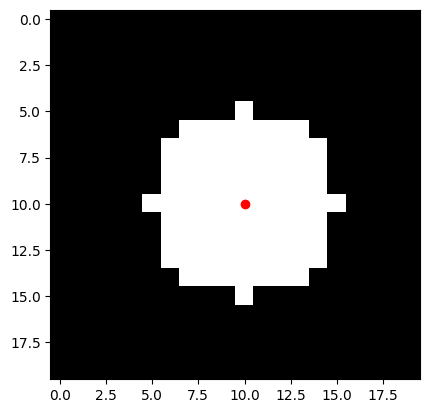

100%|██████████| 1001/1001 [05:07<00:00,  3.26it/s]


In [118]:
###...................................................Neumann boundary condition...................................................###
# Functions
def getNeighborsTemperature(grid, point, T_inf,B):
    neighbors = []
    
    rows = len(grid)
    cols = len(grid[0])

    for i in range(-1, 2):
        for j in range(-1, 2):
            try:
                if abs(i) != abs(j):
                    neighbor_temp = grid[point[0] + i][point[1] + j]
                    neighbors.append(neighbor_temp)
            except IndexError:
                ###...Edge or corner point...###
                # Upper edge point:
                if point[0] == 0:
                    # upper left corner point
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0] + 1][point[1]] # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] # j!=0
                            neighbors.append(boundary_temp)
                    # upper right corner point
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] # j!=0
                            neighbors.append(boundary_temp)
                    # upper edge
                    else:
                        boundary_temp = grid[point[0]][point[1]-1]
                        neighbors.append(boundary_temp)
                
                # lower edge point
                elif point[0] == rows - 1:
                    # Lower left corner
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0]+1][point[1]] # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower right corner
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower edge
                    else:
                        boundary_temp = grid[point[0]][point[1]+1] # j!=0
                        neighbors.append(boundary_temp)
                
                # left edge
                elif point[1] == 0:
                    boundary_temp = grid[point[0]+1][point[1]] # i!=0
                    neighbors.append(boundary_temp)
                
                # right edge
                elif point[1] == cols - 1:
                    boundary_temp = grid[point[0]-1][point[1]] # i!=0
                    neighbors.append(boundary_temp)

    return neighbors

def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/Neumann/"+ str(counter)+ ".png")
                images.append(imageio.imread("frames/Neumann/"+ str(counter)+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)


###.........Heat simulation with highest fill factor.........###
#Make mesh grid
resolution = 20
startingTemperature = 103.15 # Round about -170C°
gamma = 0.05
timeStep = 0.000158 
boundaryTemp = 103.15


#Add heat
radius_1 = 5
center_1 = (10, 10)
value_to_add = 492.2
radius_heat = 5

#Configure the grid
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
fullGridY = np.dstack([gridY,gridY2])

# create meshgrid coordinates
x = np.arange(resolution)
y = np.arange(resolution)
# create meshgrid for the x,y coordinates
X, Y = np.meshgrid(x, y)
# Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
distances = np.sqrt((X - center_1[0])**2 + (Y - center_1[1])**2)
# Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
mask = distances <= radius_1
# Aktualisiere die Werte im Gitter entsprechend der Maske
fullGridX[:,:,0][mask] += value_to_add

# Plot the created mask
white_image = Image.new('L', (20, 20), 255)
white_image = white_image * mask
plt.imshow(white_image,cmap='gray')
plt.scatter(10,10, color = "red")
plt.show()

#Run simulation
frames = [fullGridX[:,:,0].copy()]

average_temperatures_in_circle = []
for t in tqdm(range(0,1000)):
        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(fullGridX, center_1, radius_heat)
        temp_array[1].append(average_temp_in_circle)
        
        # Calculate the heat
        fullGridX = heatTransfer(fullGridX.copy(),boundaryTemp, B_i)
        frames.append(fullGridX[:,:,0].copy())


#Make Gif, saves as "simulation.gif"
makeGif_single(frames,"Neumann",timeStep,103.15,500)

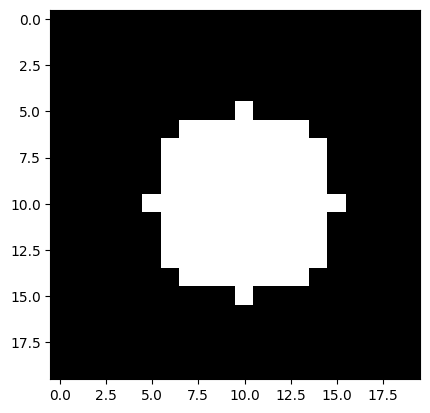

100%|██████████| 800/800 [00:02<00:00, 311.45it/s]


In [39]:
###...................................................Dirichlet boundary condition...................................................###
# Functions
def getNeighborsTemperature(grid, point, T_inf,B):
    neighbors = []
    
    rows = len(grid)
    cols = len(grid[0])

    for i in range(-1, 2):
        for j in range(-1, 2):
            try:
                if abs(i) != abs(j):
                    neighbor_temp = grid[point[0] + i][point[1] + j]
                    neighbors.append(neighbor_temp)
            except IndexError:
                neighbors.append(T_inf)

    return neighbors

def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/Dirichlet/"+ str(counter)+ ".png")
                images.append(imageio.imread("frames/Dirichlet/"+ str(counter)+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)


###.........Heat simulation with highest fill factor.........###
#Make mesh grid
resolution = 20
startingTemperature = 103.15 # Round about -170C°
gamma = 0.249
timeStep = 0.00078
boundaryTemp = 103.15


#Add heat
radius_1 = 5
center_1 = (10, 10)
value_to_add = 492.2
radius_heat = 5

#Configure the grid
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
fullGridY = np.dstack([gridY,gridY2])

# create meshgrid coordinates
x = np.arange(resolution)
y = np.arange(resolution)
# create meshgrid for the x,y coordinates
X, Y = np.meshgrid(x, y)
# Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
distances = np.sqrt((X - center_1[0])**2 + (Y - center_1[1])**2)
# Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
mask = distances <= radius_1
# Aktualisiere die Werte im Gitter entsprechend der Maske
fullGridX[:,:,0][mask] += value_to_add

# Plot the created mask
white_image = Image.new('L', (20, 20), 255)
white_image = white_image * mask
plt.imshow(white_image,cmap='gray')
plt.savefig(r'P:\Heat Transfer\Final_plots' "/"+ "Dirichlet_Robin_boundary_image"+ ".pdf")
plt.show()

#Run simulation
frames = [fullGridX[:,:,0].copy()]
temp_array[2] = []
average_temperatures_in_circle = []
for t in tqdm(range(0,800)):
        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(fullGridX, center_1, radius_heat)
        temp_array[2].append(average_temp_in_circle)
        
        # Calculate the heat
        fullGridX = heatTransfer(fullGridX.copy(),boundaryTemp, B_i)
        frames.append(fullGridX[:,:,0].copy())

#Make Gif, saves as "simulation.gif"
#makeGif_single(frames,"Dirichlet",timeStep,0,500)

In [25]:
file_path_dirichlet = 'Dirichlet_array.txt'

np.savetxt(file_path_dirichlet,temp_array[2], delimiter=',', newline='\n', fmt='%f')

dirichlet_array= np.loadtxt(file_path_dirichlet, delimiter=',')
print(len(temp_array[2]))
print(len(time_step_array))

800
800


In [33]:
def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/Dirichlet/"+ str(counter)+ ".png")
                plt.savefig("frames/Dirichlet/"+ str(counter)+ ".pdf")
                images.append(imageio.imread("frames/Dirichlet/"+ str(counter)+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)

#Make Gif, saves as "simulation.gif"
makeGif_single(frames,"Dirichlet",timeStep,103.15,500)

  0%|          | 0/801 [00:00<?, ?it/s]

100%|██████████| 801/801 [06:57<00:00,  1.92it/s]


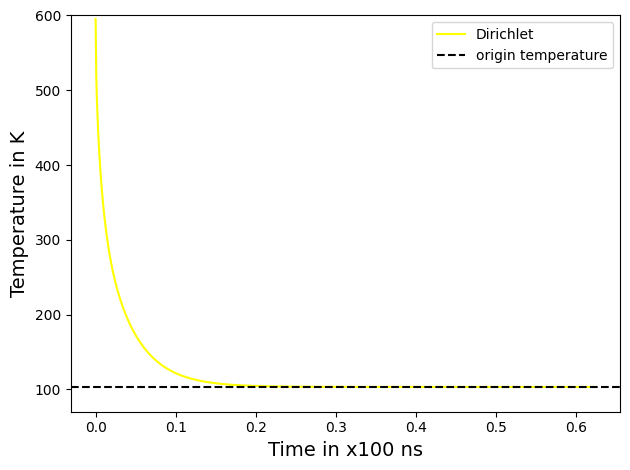

In [21]:
#Plot the Result
plt.minorticks_on
plt.xlabel(r'Time in x100 ns', fontsize="14")
plt.ylabel(r"Temperature in K", fontsize="14")


plt.plot(time_step_array, dirichlet_array, color= "yellow", label = "Dirichlet")


# Show line where the CDW Spots arge gone
plt.axhline(y=103.15, color='black', linestyle='--', label='origin temperature')
plt.ylim(70, 600)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
###...................................................No boundary...................................................###
# Functions
def getNeighborsTemperature(grid, point, T_inf,B):
    neighbors = []
    
    rows = len(grid)
    cols = len(grid[0])

    for i in range(-1, 2):
        for j in range(-1, 2):
            try:
                if abs(i) != abs(j):
                    neighbor_temp = grid[point[0] + i][point[1] + j]
                    neighbors.append(neighbor_temp)
            except IndexError:
                neighbors.append(T_inf)

    return neighbors

def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/no_boundary/"+ str(counter)+ ".png")
                images.append(imageio.imread("frames/no_boundary/"+ str(counter)+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)


###.........Heat simulation with highest fill factor.........###
#Make mesh grid
resolution = 100
startingTemperature = 103.15 # Round about -170C°
gamma = 0.249
timeStep = 0.00078
boundaryTemp = 103.15


#Add heat
radius_1 = 5
center_1 = (50, 50)
value_to_add = 492.2
radius_heat = 5

#Configure the grid
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
fullGridY = np.dstack([gridY,gridY2])

# create meshgrid coordinates
x = np.arange(resolution)
y = np.arange(resolution)
# create meshgrid for the x,y coordinates
X, Y = np.meshgrid(x, y)
# Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
distances = np.sqrt((X - center_1[0])**2 + (Y - center_1[1])**2)
# Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
mask = distances <= radius_1
# Aktualisiere die Werte im Gitter entsprechend der Maske
fullGridX[:,:,0][mask] += value_to_add

# Plot the created mask
white_image = Image.new('L', (100, 100), 255)
white_image = white_image * mask
plt.imshow(white_image,cmap='gray')
plt.savefig(r'P:\Heat Transfer\Final_plots' "/"+ "no_boundary_image"+ ".pdf")
plt.show()

#Run simulation
frames = [fullGridX[:,:,0].copy()]

average_temperatures_in_circle = []
temp_array[3] = []
for t in tqdm(range(0,800)):
        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(fullGridX, center_1, radius_heat)
        temp_array[3].append(average_temp_in_circle)
        
        # Calculate the heat
        fullGridX = heatTransfer(fullGridX.copy(),boundaryTemp, B_i)
        frames.append(fullGridX[:,:,0].copy())

#Make Gif, saves as "simulation.gif"
#makeGif_single(frames,"no_boundary",timeStep,103.15,500)

In [14]:

file_path_no_boundary = 'boundary_no_array.txt'

np.savetxt(file_path_no_boundary,temp_array[3], delimiter=',', newline='\n', fmt='%f')

no_boundary_array = np.loadtxt(file_path_no_boundary, delimiter=',')
print(len(temp_array[3]))
print(len(time_step_array))

800
800


In [35]:
def makeGif_single(frames,name,timeStep,minTemp,maxTemp):
        counter=0
        images = []
        for i in tqdm(range(0,len(frames))):
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.pcolormesh(frames[i], cmap = "inferno" , vmin = minTemp, vmax = maxTemp)
                plt.colorbar()
                plt.savefig("frames/no_boundary/"+ str(counter)+ ".png")
                plt.savefig("frames/no_boundary/"+ str(counter)+ ".pdf")
                images.append(imageio.imread("frames/no_boundary/"+ str(counter)+ ".png"))
                counter += 1
                plt.close()

        imageio.mimsave(name + ".gif", images)

#Make Gif, saves as "simulation.gif"
makeGif_single(frames,"no_boundary",timeStep,103.15,500)

100%|██████████| 801/801 [18:57<00:00,  1.42s/it]


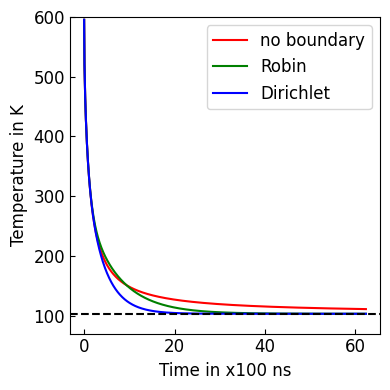

In [37]:
#Plot the Result
plt.figure(figsize=(4,4))
plt.minorticks_on
plt.xlabel(r'Time in x100 ns', fontsize="12")
plt.ylabel(r"Temperature in K", fontsize="12")


plt.plot(time_step_array, no_boundary_array, color= "red", label = "no boundary")
plt.plot(time_step_array, robin_array, color= "green", label = "Robin")
plt.plot(time_step_array, dirichlet_array, color= "blue", label = "Dirichlet")


# Show line where the CDW Spots arge gone
plt.axhline(y=103.15, color='black', linestyle='--')
plt.ylim(70, 600)
plt.legend(loc="upper right", fontsize = 12)


#Set the ricks direction inwards
plt.tick_params(axis='both', which='major', direction='in')
plt.tick_params(axis='both', which='minor', direction='in')

plt.tick_params(axis='both', labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(r'P:\Heat Transfer\Final_plots' "/"+ "compare_boundary"+ ".pdf")
plt.show()

In [ ]:
file_path = 'Boundary_array.txt'

np.savetxt(file_path,temp_array, delimiter=',', newline='\n', fmt='%f')

loaded_array= np.loadtxt(file_path, delimiter=',')